In [8]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import  ncx2
import pandas as pd

In [9]:
class StochasticProcess:
    def __init__(self, params, T, Nx, Nt, init_state = None):
        self.params = params
        self.T = T
        self.Nx = Nx # Number of trajectories
        self.Nt = Nt # Number of discretization steps
        self.init_state = init_state

        #Wiener Process by default
        self.bxt = lambda x: 0
        self.sigmaxt = lambda x: 1
        self.bxt_x = lambda x: 0
        self.bxt_xx = lambda x: 0
        self.sigmaxt_x = lambda x: 0
        self.sigmaxt_xx = lambda x: 0

    def DefaultInitState(self):
        return np.zeros(self.Nx)

    def SampleFromDensity(self, x0, t, t0):
        result = np.zeros(self.Nx)
        for k in range(0, self.Nx):
            result[k] = x0[k] + np.random.normal(0, 1) * np.sqrt(t - t0)
        return result

    def PathGenerator(self):
        dt = self.T / self.Nt
        t_data = np.linspace(0, self.T, self.Nt + 1)
        x_data = np.zeros((self.Nt + 1, self.Nx))

        if self.init_state is None:
            x_data[0] = self.DefaultInitState()
        else:
            x_data[0] = self.init_state

        for i in range(1, self.Nt + 1):
            x_data[i] = self.SampleFromDensity(x_data[i - 1], t_data[i], t_data[i - 1])
        return t_data, x_data

    def ExactSolution(self, dwt):
        dt = self.T / self.Nt
        t_data = np.linspace(0, self.T, self.Nt + 1)
        x_data = np.zeros((self.Nt + 1, self.Nx))

        if self.init_state is None:
            x_data[0] = self.DefaultInitState()
        else:
            x_data[0] = self.init_state

        for i in range(1, self.Nt + 1):
            x_data[i] = x_data[i - 1] + dwt[i - 1]
        return t_data, x_data

    def EulerSolution(self, dwt):
        dt = self.T / self.Nt
        t_data = np.linspace(0, self.T, self.Nt + 1)
        x_data = np.zeros((self.Nt + 1, self.Nx))

        if self.init_state is None:
            x_data[0] = self.DefaultInitState()
        else:
            x_data[0] = self.init_state

        for i in range(1, self.Nt + 1):
            x_data[i] = x_data[i - 1] + self.bxt(x_data[i - 1]) * dt + self.sigmaxt(x_data[i - 1]) * dwt[i - 1]
        return t_data, x_data

    def Milstein1Solution(self, dwt):
        dt = self.T / self.Nt
        t_data = np.linspace(0, self.T, self.Nt + 1)
        x_data = np.zeros((self.Nt + 1, self.Nx))

        if self.init_state is None:
            x_data[0] = self.DefaultInitState()
        else:
            x_data[0] = self.init_state

        for i in range(1, self.Nt + 1):
            x_data[i] = x_data[i - 1] + self.bxt(x_data[i - 1]) * dt + self.sigmaxt(x_data[i - 1]) * dwt[i - 1] + \
                        1/2 * self.sigmaxt(x_data[i - 1]) * self.sigmaxt_x(x_data[i - 1]) * (dwt[i - 1]**2 - dt)
        return t_data, x_data

    def Milstein2Solution(self, dwt):
        dt = self.T / self.Nt
        t_data = np.linspace(0, self.T, self.Nt + 1)
        x_data = np.zeros((self.Nt + 1, self.Nx))

        if self.init_state is None:
            x_data[0] = self.DefaultInitState()
        else:
            x_data[0] = self.init_state

        for i in range(1, self.Nt + 1):
            x_data[i] = x_data[i - 1] + (self.bxt(x_data[i - 1]) - 1/2 * self.sigmaxt(x_data[i - 1]) * self.sigmaxt_x(x_data[i - 1])) * dt +\
                        self.sigmaxt(x_data[i - 1]) * dwt[i - 1] + 1/2 * self.sigmaxt(x_data[i - 1]) * self.sigmaxt_x(x_data[i - 1]) * dwt[i - 1]**2 +\
                        (1/2 * self.bxt(x_data[i - 1]) * self.sigmaxt_x(x_data[i - 1]) + 1/2 * self.bxt_x(x_data[i - 1]) * self.sigmaxt(x_data[i - 1]) +\
                        1/4 * self.sigmaxt(x_data[i - 1])**2 * self.sigmaxt_xx(x_data[i - 1])) * dt * dwt[i - 1] +\
                        (1/2 * self.bxt(x_data[i - 1]) * self.bxt_x(x_data[i - 1]) + 1/4 * self.bxt_xx(x_data[i - 1]) * self.sigmaxt(x_data[i - 1])**2) * dt**2
        return t_data, x_data

    def PredictorCorrectorSolution(self, dwt, eta = 1/2, alpha = 1/2):
        dt = self.T / self.Nt
        t_data = np.linspace(0, self.T, self.Nt + 1)
        x_data = np.zeros((self.Nt + 1, self.Nx))

        if self.init_state is None:
            x_data[0] = self.DefaultInitState()
        else:
            x_data[0] = self.init_state

        for i in range(1, self.Nt + 1):
            yw = x_data[i - 1] + self.bxt(x_data[i - 1]) * dt + self.sigmaxt(x_data[i - 1]) * dwt[i - 1]
            bwim1 = self.bxt(x_data[i - 1]) - eta * self.sigmaxt(x_data[i - 1]) * self.sigmaxt_x(x_data[i - 1])
            bwi = self.bxt(yw) - eta * self.sigmaxt(yw) * self.sigmaxt_x(yw)
            x_data[i] = x_data[i - 1] + alpha * bwi * dt + (1 - alpha) * bwim1 * dt +\
                        eta * self.sigmaxt(yw) * dwt[i - 1] + (1 - eta) * self.sigmaxt(x_data[i - 1]) * dwt[i - 1]
        return t_data, x_data


class OUprocess(StochasticProcess):
    def __init__(self, params, T, Nx, Nt, init_state = None):
        super().__init__(params, T, Nx, Nt, init_state)

        # params = [theta, mu, sigma]
        self.bxt = lambda x: self.params[0] * (self.params[1] - x)
        self.sigmaxt = lambda x: self.params[2]
        self.bxt_x = lambda x: -self.params[0]

    def DefaultInitState(self):
        return self.params[1] * np.ones(self.Nx)

    def StationaryState(self):
        theta = self.params[0]
        mu = self.params[1]
        sigma = self.params[2]

        result = np.zeros(self.Nx)

        for j in range(0, self.Nx):
            m = mu
            v = sigma**2 / (2 * theta)
            result[j] = np.random.normal(m, np.sqrt(v))
        return result

    def SampleFromDensity(self, x0, t, t0):
        theta = self.params[0]
        mu = self.params[1]
        sigma = self.params[2]

        result = np.zeros(self.Nx)

        for j in range(0, self.Nx):
            m = mu + (x0[j] - mu) * np.exp(-theta * (t - t0))
            v = sigma**2 / (2 * theta) * (1 - np.exp(-2 * theta * (t - t0)))
            result[j] = np.random.normal(m, np.sqrt(v))
        return result

    def ExactSolution(self, dwt):
        dt = self.T / self.Nt
        t_data = np.linspace(0, self.T, self.Nt + 1)
        x_data = np.zeros((self.Nt + 1, self.Nx))

        theta = self.params[0]
        mu = self.params[1]
        sigma = self.params[2]

        if self.init_state is None:
            x_data[0] = self.DefaultInitState()
        else:
            x_data[0] = self.init_state

        Ito_integral_sum = np.zeros(self.Nx)
        Determinated_part = mu + (x_data[0] - mu) * np.exp(-theta * t_data)
        for i in range(1, self.Nt + 1):
            Ito_integral_sum += sigma * np.exp(theta * t_data[i - 1]) * dwt[i - 1]
            x_data[i] = Determinated_part[i] + Ito_integral_sum * np.exp(-theta * t_data[i])
        return t_data, x_data


class CIRprocess(StochasticProcess):
    def __init__(self, params, T, Nx, Nt, init_state = None):
        super().__init__(params, T, Nx, Nt, init_state)

        # params = [theta1, theta2, theta3]
        self.bxt = lambda x: self.params[0] - self.params[1] * x
        self.sigmaxt = lambda x: self.params[2] * np.sqrt(np.maximum(x, 0))
        self.bxt_x = lambda x: - self.params[1]
        self.sigmaxt_x = lambda x: self.params[2] * 1 / (2 * np.sqrt(np.maximum(x, 0)))
        self.sigmaxt_xx = lambda x: -self.params[2] * 1 / (4 * np.maximum(x, 0)**(1/4))

    def DefaultInitState(self):
        return self.params[0] / self.params[1] * np.ones(self.Nx)

    def StationaryState(self):
        theta1 = self.params[0]
        theta2 = self.params[1]
        theta3 = self.params[2]

        k = theta2
        theta = theta1 / theta2
        sigma = theta3

        result = np.zeros(self.Nx)

        for j in range(0, self.Nx):
            c = 2 * k / (sigma**2)
            u = 0
            q = 2 * k * theta / sigma**2 - 1
            result[j] = ncx2.rvs(2 * q + 2, 2 * u) / (2 * c)
        return result

    def SampleFromDensity(self, x0, t, t0):
        theta1 = self.params[0]
        theta2 = self.params[1]
        theta3 = self.params[2]

        k = theta2
        theta = theta1 / theta2
        sigma = theta3

        result = np.zeros(self.Nx)

        for j in range(0, self.Nx):
            c = 2 * k / (sigma**2 * (1 - np.exp(-k * (t - t0))))
            u = c * x0[j] * np.exp(-k * (t - t0))
            #v = c * x
            q = 2 * k * theta / sigma**2 - 1
            result[j] = ncx2.rvs(2 * q + 2, 2 * u) / (2 * c)
        return result

    def ExactSolution(self, dwt):
        dt = self.T / self.Nt
        t_data = np.linspace(0, self.T, self.Nt + 1)
        x_data = np.zeros((self.Nt + 1, self.Nx))

        theta1 = self.params[0]
        theta2 = self.params[1]
        theta3 = self.params[2]

        if self.init_state is None:
            x_data[0] = self.DefaultInitState()
        else:
            x_data[0] = self.init_state

        Ito_integral_sum = np.zeros(self.Nx)
        Determinated_part = (x_data[0] - theta1 / theta2) * np.exp(-theta2 * t_data) + theta1/theta2
        for i in range(1, self.Nt + 1):
            Ito_integral_sum += theta3 * np.exp(theta2 * t_data[i - 1]) * np.sqrt(np.maximum(x_data[i - 1], 0)) * dwt[i - 1]
            x_data[i] = Determinated_part[i] + Ito_integral_sum * np.exp(-theta2 * t_data[i])
        return t_data, x_data


class BSMprocess(StochasticProcess):
    def __init__(self, params, T, Nx, Nt, init_state = None):
        super().__init__(params, T, Nx, Nt, init_state)

        # params = [theta1, theta2] or [r, sigma]
        self.bxt = lambda x: self.params[0] * x
        self.sigmaxt = lambda x: self.params[1] * x
        self.bxt_x = lambda x: self.params[0]
        self.sigmaxt_x = lambda x: self.params[1]

    def DefaultInitState(self):
        return np.ones(self.Nx)

    def SampleFromDensity(self, x0, t, t0):
        r = self.params[0]
        sigma = self.params[1]

        result = np.zeros(self.Nx)

        m = (r - 1/2 * sigma**2) * (t - t0)
        v = sigma**2 * (t - t0)

        for j in range(0, self.Nx):
            result[j] = x0[j] * np.random.lognormal(m, np.sqrt(v))
        return result

    def ExactSolution(self, dwt):
        dt = self.T / self.Nt
        t_data = np.linspace(0, self.T, self.Nt + 1)
        x_data = np.zeros((self.Nt + 1, self.Nx))

        r = self.params[0]
        sigma = self.params[1]

        if self.init_state is None:
            x_data[0] = self.DefaultInitState()
        else:
            x_data[0] = self.init_state

        for i in range(1, self.Nt + 1):
            x_data[i] = x_data[i - 1] * np.exp((r - sigma**2 / 2) * dt + sigma * dwt[i - 1])
        return t_data, x_data

Task 1. Suppose we have a   Brownian motion  defined by
 $$
 dX_t = \theta_1 X_tdt + \theta_2X_tdW_t, \quad X_0 = 1, \text{ with } (\theta_1, \theta_2) = (2, 0.5).
 $$
Compare approximations
*   the Euler approximation algorithm;
*   the 1st Milstein scheme;
*   the 2nd Milstein scheme;
*   the predictor-corrector method  (set default $\alpha = \eta = 1/2$);
*   KPS method

with the exact solution on $[0,1]$, levels of discretization $N=1024$.

In [10]:
T = 1
Nx = 1
Nt = 1024

x0 = 1
init_state = x0 * np.ones(Nx)

#theta = 2
#mu = 10
#sigma = 3.5
#params = [theta, mu, sigma]

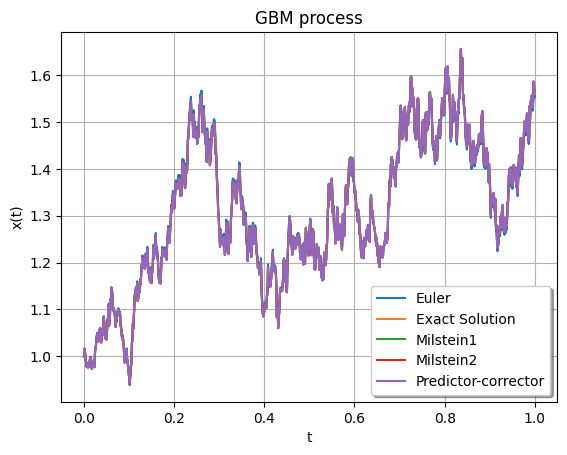

In [11]:
theta1 = 1
theta2 = 1/2
params = [theta1, theta2]

dwt = np.random.normal(0, 1, size = (Nt, Nx)) * np.sqrt(T/Nt)


BSMp = BSMprocess(params, T, Nx, Nt, init_state)
t_data, x_data = BSMp.EulerSolution(dwt)
plt.plot(t_data, x_data, label = 'Euler')

t_data, x_data = BSMp.ExactSolution(dwt)
plt.plot(t_data, x_data, label = 'Exact Solution')

t_data, x_data = BSMp.Milstein1Solution(dwt)
plt.plot(t_data, x_data, label = 'Milstein1')

t_data, x_data = BSMp.Milstein2Solution(dwt)
plt.plot(t_data, x_data, label = 'Milstein2')

t_data, x_data = BSMp.PredictorCorrectorSolution(dwt, 1/2, 1/2)
plt.plot(t_data, x_data, label = 'Predictor-corrector')

plt.title("GBM process")
plt.legend(loc = 'best', fancybox = True, shadow = True)
plt.xlabel("t")
plt.ylabel("x(t)")
plt.grid(True)
plt.show()

Task. Compare the different approximations and the exact solution Brownian motion
for different levels of discretization
$$
N=\{2, 4, 8, 128, 256, 512, 1024, 8192, 16384, 32768\}
$$
being the number of subintervals of $[0,1]$.
As the result provide the table with maximum absolute difference.


       N  Euler Max Abs Diff  Milstein1 Max Abs Diff  Milstein2 Max Abs Diff  \
0      2            0.723268                2.454809                0.384531   
1      4            0.826597                1.314160                1.031449   
2      8            2.853159                3.034395                2.464235   
3    128            1.047765                1.219636                0.857762   
4    256            1.973248                0.744863                1.325028   
5    512            0.774167                1.148960                1.735450   
6   1024            1.001199                0.918262                1.688668   
7   8192            1.193815                1.412884                1.665554   
8  16384            1.048456                1.994479                1.362587   
9  32768            1.273958                1.972820                3.043075   

   Predictor-Corrector Max Abs Diff  KPS Max Abs Diff  
0                          1.469217          0.875243  
1      

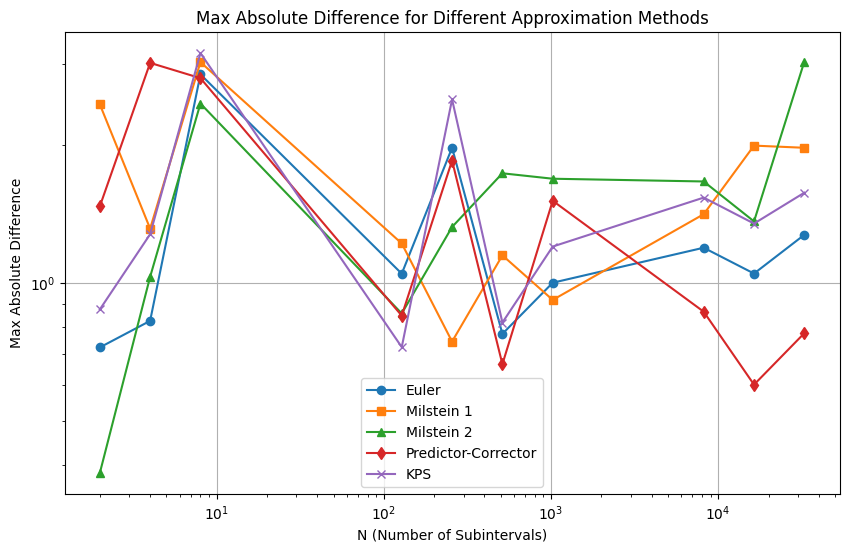

In [12]:
# Параметры задачи
T = 1  # Время
Nx = 1  # Одна траектория броуновского движения
N_values = [2, 4, 8, 128, 256, 512, 1024, 8192, 16384, 32768]  # Число шагов

# Генерация траектории броуновского движения
def exact_brownian_motion(T, N):
    dt = T / N
    dW = np.random.normal(0, np.sqrt(dt), N)  # приращения Винеровского процесса
    W = np.cumsum(dW)  # накопленные суммы приращений
    W = np.insert(W, 0, 0)  # начальное состояние 0
    return W

# Эйлеровская аппроксимация
def euler_approximation(T, N):
    dt = T / N
    dW = np.random.normal(0, np.sqrt(dt), N)
    W_euler = np.cumsum(dW)
    W_euler = np.insert(W_euler, 0, 0)
    return W_euler

# Первая схема Милштейна
def milstein1_approximation(T, N):
    dt = T / N
    dW = np.random.normal(0, np.sqrt(dt), N)
    W_milstein1 = np.cumsum(dW + 0.5 * (dW ** 2 - dt))
    W_milstein1 = np.insert(W_milstein1, 0, 0)
    return W_milstein1

# Вторая схема Милштейна
def milstein2_approximation(T, N):
    dt = T / N
    dW = np.random.normal(0, np.sqrt(dt), N)
    W_milstein2 = np.zeros(N + 1)
    for i in range(1, N + 1):
        W_milstein2[i] = W_milstein2[i - 1] + dW[i - 1] + 0.5 * (dW[i - 1]**2 - dt) + \
                         0.5 * W_milstein2[i - 1] * dW[i - 1] * dt
    return W_milstein2

# Предиктор-корректор
def predictor_corrector_approximation(T, N, alpha=0.5, eta=0.5):
    dt = T / N
    dW = np.random.normal(0, np.sqrt(dt), N)
    W_pred_corr = np.zeros(N + 1)
    for i in range(1, N + 1):
        yw = W_pred_corr[i - 1] + dW[i - 1]
        W_pred_corr[i] = W_pred_corr[i - 1] + alpha * yw * dt + eta * dW[i - 1]
    return W_pred_corr

# KPS метод
def kps_approximation(T, N):
    dt = T / N
    dW = np.random.normal(0, np.sqrt(dt), N)
    W_kps = np.zeros(N + 1)
    for i in range(1, N + 1):
        delta_kps = dW[i - 1] + 0.5 * (dW[i - 1]**2 - dt)
        W_kps[i] = W_kps[i - 1] + delta_kps
    return W_kps

# Таблица с максимальными абсолютными отклонениями
results = []

for N in N_values:
    exact_solution = exact_brownian_motion(T, N)
    
    euler_sol = euler_approximation(T, N)
    milstein1_sol = milstein1_approximation(T, N)
    milstein2_sol = milstein2_approximation(T, N)
    predictor_corr_sol = predictor_corrector_approximation(T, N)
    kps_sol = kps_approximation(T, N)
    
    max_diff_euler = np.max(np.abs(exact_solution - euler_sol))
    max_diff_milstein1 = np.max(np.abs(exact_solution - milstein1_sol))
    max_diff_milstein2 = np.max(np.abs(exact_solution - milstein2_sol))
    max_diff_predictor_corr = np.max(np.abs(exact_solution - predictor_corr_sol))
    max_diff_kps = np.max(np.abs(exact_solution - kps_sol))
    
    results.append([N, max_diff_euler, max_diff_milstein1, max_diff_milstein2, max_diff_predictor_corr, max_diff_kps])

# Создание таблицы результатов
df_results = pd.DataFrame(results, columns=["N", "Euler Max Abs Diff", "Milstein1 Max Abs Diff", 
                                            "Milstein2 Max Abs Diff", "Predictor-Corrector Max Abs Diff", 
                                            "KPS Max Abs Diff"])

# Печать результатов
print(df_results)

# Построение графика
plt.figure(figsize=(10, 6))

plt.plot(df_results['N'], df_results['Euler Max Abs Diff'], label='Euler', marker='o')
plt.plot(df_results['N'], df_results['Milstein1 Max Abs Diff'], label='Milstein 1', marker='s')
plt.plot(df_results['N'], df_results['Milstein2 Max Abs Diff'], label='Milstein 2', marker='^')
plt.plot(df_results['N'], df_results['Predictor-Corrector Max Abs Diff'], label='Predictor-Corrector', marker='d')
plt.plot(df_results['N'], df_results['KPS Max Abs Diff'], label='KPS', marker='x')

plt.xscale('log')  # Логарифмическая шкала по оси x
plt.yscale('log')  # Логарифмическая шкала по оси y
plt.xlabel('N (Number of Subintervals)')
plt.ylabel('Max Absolute Difference')
plt.title('Max Absolute Difference for Different Approximation Methods')
plt.legend()
plt.grid(True)

plt.show()

Task. Conduct a study of the influence of the choice of values $\alpha$ and $\eta$ ​​on the accuracy of the  solution and plot a 3D graph where the x-axis is $α$'s values, y-axis is $\eta$'s values, and z-axis are maximum absolute difference between the exact solution and the predictor-corrector approximation.



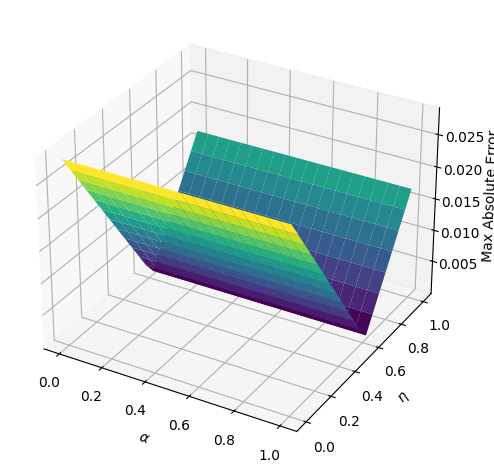

In [17]:
from mpl_toolkits.mplot3d import Axes3D

def exact_solution(params, dwt, Nt, Nx):
    dt = 1.0 / Nt
    x_data = np.ones(Nx)

    for i in range(1, Nt + 1):
        x_data *= np.exp((params[0] - 0.5 * params[1] ** 2) * dt + params[1] * dwt[i - 1])

    return x_data

def predictor_corrector_solution(params, dwt, Nt, Nx, eta=1/2, alpha=1/2):
    dt = 1.0 / Nt
    x_data = np.ones(Nx)

    for t in range(1, Nt + 1):
        yw = x_data * (1 + params[0] * dt + params[1] * dwt[t - 1])  # Predictor
        bwi = params[0]  # Считаем производную b
        bwim1 = params[0]  # Предыдущая производная

        x_data = x_data + alpha * bwi * dt + (1 - alpha) * bwim1 * dt + \
                 eta * params[1] * dwt[t - 1]

    return x_data

def study_alpha_eta(params, alphas, etas, Nt, Nx):
    dt = 1.0 / Nt
    dwt = np.random.normal(0, 1, size=(Nt, Nx)) * np.sqrt(dt)

    exact_sol = exact_solution(params, dwt, Nt, Nx)

    # Store errors for different alpha and eta values
    errors = np.zeros((len(alphas), len(etas)))

    for i, alpha in enumerate(alphas):
        for j, eta in enumerate(etas):
            approx_sol = predictor_corrector_solution(params, dwt, Nt, Nx, eta=eta, alpha=alpha)
            errors[i, j] = np.max(np.abs(exact_sol - approx_sol))

    return errors

def plot_error_surface(alphas, etas, errors):
    alpha_grid, eta_grid = np.meshgrid(alphas, etas)

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(alpha_grid, eta_grid, errors.T, cmap='viridis')
    ax.set_xlabel(r'$\alpha$')
    ax.set_ylabel(r'$\eta$')
    ax.set_zlabel('Max Absolute Error')
    plt.tight_layout()
    plt.show()

# Параметры
r = 0.05  # Безрисковая ставка
sigma = 0.2  # Волатильность
params = [r, sigma]
Nt = 1000  # Количество временных шагов
Nx = 1  # Количество активов

# Определим диапазон значений alpha и eta
alphas = np.linspace(0, 1, 20)
etas = np.linspace(0, 1, 20)

# Изучаем влияние alpha и eta на точность решения
errors = study_alpha_eta(params, alphas, etas, Nt, Nx)

# Строим график
plot_error_surface(alphas, etas, errors)

Task 2.  Repeat the Task 1 for the Cox-Ingersoll-Ross process
$$
dX_t = (\theta_1 - \theta_2X_t)dt + \theta_3 \sqrt{ X_t}dW_t, X_0 = 10, (\theta_1, \theta_2, \theta_3) = (6, 3, 2).
$$

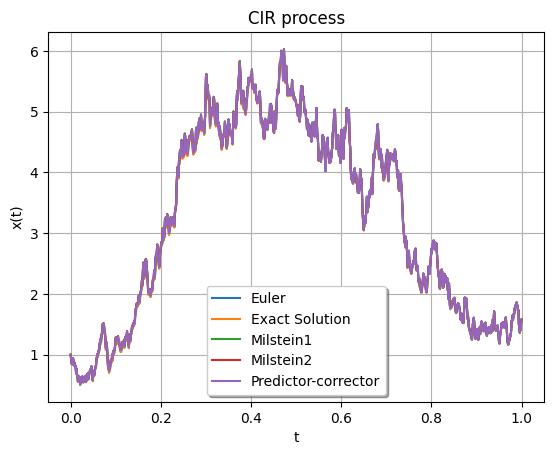

In [ ]:
theta1 = 6
theta2 = 3
theta3 = 2
params = [theta1, theta2, theta3]

dwt = np.random.normal(0, 1, size = (Nt, Nx)) * np.sqrt(T/Nt)

CIRp = CIRprocess(params, T, Nx, Nt, init_state)
t_data, x_data = CIRp.EulerSolution(dwt)
plt.plot(t_data, x_data, label = 'Euler')

t_data, x_data = CIRp.ExactSolution(dwt)
plt.plot(t_data, x_data, label = 'Exact Solution')

t_data, x_data = CIRp.Milstein1Solution(dwt)
plt.plot(t_data, x_data, label = 'Milstein1')

t_data, x_data = CIRp.Milstein2Solution(dwt)
plt.plot(t_data, x_data, label = 'Milstein2')

t_data, x_data = CIRp.PredictorCorrectorSolution(dwt, 0.4, 0.6)
plt.plot(t_data, x_data, label = 'Predictor-corrector')

plt.title("CIR process")
plt.legend(loc = 'best', fancybox = True, shadow = True)
plt.xlabel("t")
plt.ylabel("x(t)")
plt.grid(True)
plt.show()

Task. Compare the speed of convergence for four schemes from Task 1 with extract solution on the graph where the x-axis is  log(N) values, y-axis is  X(t). See example in the study aid.

100%|██████████| 10/10 [00:00<00:00, 96.51it/s]


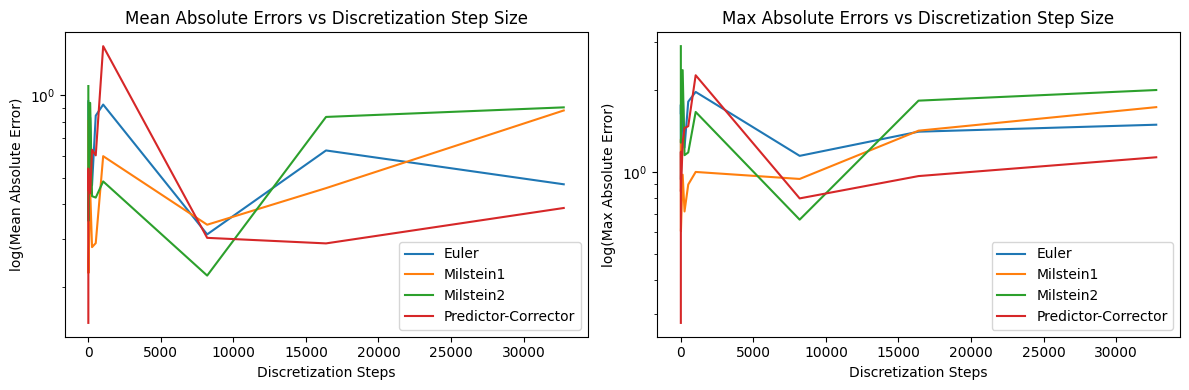

In [21]:
from tqdm import tqdm

# Параметры задачи
T = 1  # Время
N_values = [2, 4, 8, 128, 256, 512, 1024, 8192, 16384, 32768]  # Число шагов

# Генерация траектории броуновского движения
def exact_brownian_motion(T, N):
    dt = T / N
    dW = np.random.normal(0, np.sqrt(dt), N)  # Приращения Винеровского процесса
    W = np.cumsum(dW)  # Накопленные суммы приращений
    W = np.insert(W, 0, 0)  # Начальное состояние 0
    return W

# Эйлеровская аппроксимация
def euler_approximation(T, N):
    dt = T / N
    dW = np.random.normal(0, np.sqrt(dt), N)
    W_euler = np.cumsum(dW)
    W_euler = np.insert(W_euler, 0, 0)
    return W_euler

# Первая схема Милштейна
def milstein1_approximation(T, N):
    dt = T / N
    dW = np.random.normal(0, np.sqrt(dt), N)
    W_milstein1 = np.cumsum(dW + 0.5 * (dW ** 2 - dt))
    W_milstein1 = np.insert(W_milstein1, 0, 0)
    return W_milstein1

# Вторая схема Милштейна
def milstein2_approximation(T, N):
    dt = T / N
    dW = np.random.normal(0, np.sqrt(dt), N)
    W_milstein2 = np.zeros(N + 1)
    for i in range(1, N + 1):
        W_milstein2[i] = W_milstein2[i - 1] + dW[i - 1] + 0.5 * (dW[i - 1]**2 - dt) + \
                         0.5 * W_milstein2[i - 1] * dW[i - 1] * dt
    return W_milstein2

# Предиктор-корректор
def predictor_corrector_approximation(T, N, alpha=0.5, eta=0.5):
    dt = T / N
    dW = np.random.normal(0, np.sqrt(dt), N)
    W_pred_corr = np.zeros(N + 1)
    for i in range(1, N + 1):
        yw = W_pred_corr[i - 1] + dW[i - 1]
        W_pred_corr[i] = W_pred_corr[i - 1] + alpha * yw * dt + eta * dW[i - 1]
    return W_pred_corr

# Сбор результатов
results_mean = []
results_max = []

for N in tqdm(N_values):
    exact_solution = exact_brownian_motion(T, N)
    
    euler_sol = euler_approximation(T, N)
    milstein1_sol = milstein1_approximation(T, N)
    milstein2_sol = milstein2_approximation(T, N)
    predictor_corr_sol = predictor_corrector_approximation(T, N)
    
    # Считаем ошибки
    abs_errors = {
        'Euler': np.abs(exact_solution - euler_sol),
        'Milstein1': np.abs(exact_solution - milstein1_sol),
        'Milstein2': np.abs(exact_solution - milstein2_sol),
        'Predictor-Corrector': np.abs(exact_solution - predictor_corr_sol)
    }
    
    # Средние и максимальные ошибки
    for name, errors in abs_errors.items():
        mean_error = np.mean(errors)
        max_error = np.max(errors)
        results_mean.append({'discretization': N, 'mean': mean_error, 'name': name})
        results_max.append({'discretization': N, 'max': max_error, 'name': name})

# Преобразуем результаты в DataFrame
mean_df = pd.DataFrame(results_mean)
max_df = pd.DataFrame(results_max)

# Построение графиков
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

# График средних абсолютных ошибок
for name in mean_df.name.unique():
    means = mean_df[mean_df.name == name]['mean'].to_list()
    desc = mean_df[mean_df.name == name].discretization.to_list()
    axs[0].plot(desc, means, label=name)

axs[0].set_yscale('log')
axs[0].set_xlabel('Discretization Steps')
axs[0].set_ylabel('log(Mean Absolute Error)')
axs[0].set_title('Mean Absolute Errors vs Discretization Step Size')
axs[0].legend()

# График максимальных абсолютных ошибок
for name in max_df.name.unique():
    maxes = max_df[max_df.name == name]['max'].to_list()
    desc = max_df[max_df.name == name].discretization.to_list()
    axs[1].plot(desc, maxes, label=name)

axs[1].set_yscale('log')
axs[1].set_xlabel('Discretization Steps')
axs[1].set_ylabel('log(Max Absolute Error)')
axs[1].set_title('Max Absolute Errors vs Discretization Step Size')
axs[1].legend()

plt.tight_layout()
plt.show()

Task 3. Generate 100 paths using conditional distribution of
* Ornstein-Uhlenbeck process $θ = (1, 1, 0.5)$,
* Geometric Brownian motion process $θ = (0.3, 0.1)$,
* Cox-Ingersoll-Ross process $θ = (0.4, 0.3, 0.2)$

with $X_0=0.5$.
Plot the random path for each process.

In [ ]:
Nx = 100
Nt = 300

T = 1

params_OU = [1, 1, 0.5]
params_BSM = [0.3, 0.1]
params_CIR = [0.4, 0.3, 0.2]

init_state = 0.5 * np.ones(Nx)

OUp = OUprocess(params_OU, T, Nx, Nt, init_state)
BSMp = BSMprocess(params_BSM, T, Nx, Nt, init_state)
CIRp = CIRprocess(params_CIR, T, Nx, Nt, init_state)

t_data, x_data_OU = OUp.PathGenerator()
t_data, x_data_BSM = BSMp.PathGenerator()
t_data, x_data_CIR = CIRp.PathGenerator()

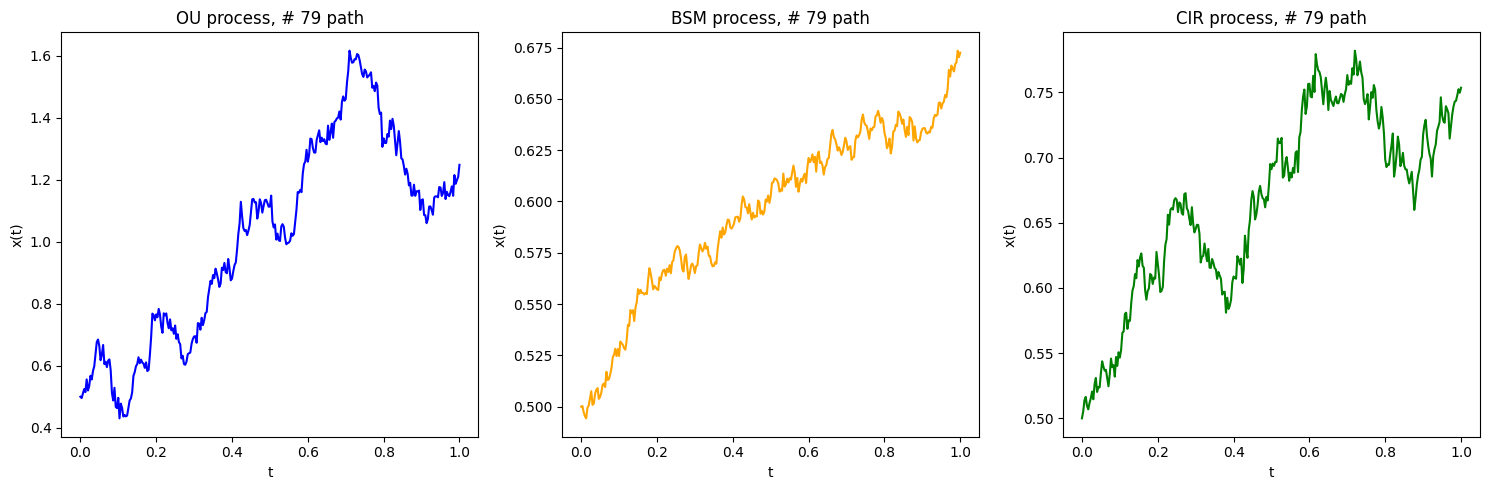

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

n = np.random.randint(0, Nx)

axs[0].plot(t_data, x_data_OU[:,n], color='blue')
axs[0].set_title(f'OU process, # {n} path')
axs[0].set_xlabel('t')
axs[0].set_ylabel('x(t)')

axs[1].plot(t_data, x_data_BSM[:,n], color='orange')
axs[1].set_title(f'BSM process, # {n} path')
axs[1].set_xlabel('t')
axs[1].set_ylabel('x(t)')

axs[2].plot(t_data, x_data_CIR[:,n], color='green')
axs[2].set_title(f'CIR process, # {n} path')
axs[2].set_xlabel('t')
axs[2].set_ylabel('x(t)')

plt.tight_layout()

plt.show()

Task. Using the class template from Task 1, create class and design the path generator for one from the following processes:

1.   Modified CIR model;
2.   Chan-Karolyi-Longstaff-Sanders family of models;
1.   Nonlinear mean reversion Ait-Sahalia model;
2.   Jacobi diffusion process;
1.   Ahn and Gao (inverse of Feller’s square root) model;
2.   Radial Ornstein-Uhlenbeck process.

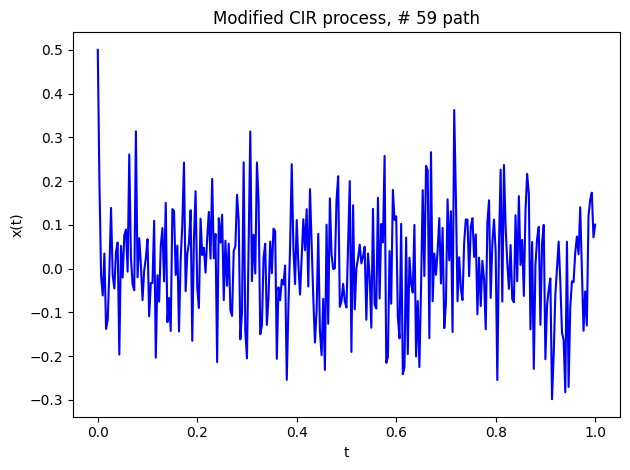

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import t, uniform

class ModifiedCIRprocess:
    def __init__(self, params, T, Nx, Nt, init_state=None):
        self.params = params  # [theta1, theta2]
        self.T = T
        self.Nx = Nx
        self.Nt = Nt
        self.dt = T / Nt
        self.init_state = init_state if init_state is not None else self.DefaultInitState()

    def DefaultInitState(self):
        return np.full(self.Nx, 0.5)  # Начальное состояние 0.5

    def StationaryState(self):
        theta1, theta2 = self.params
        nu = 1 + (2 * theta1) / (theta2 ** 2)
        result = t.rvs(df=nu, size=self.Nx) / np.sqrt(nu)
        return result

    def SampleFromDensity(self, x0, t1, t0):
        theta1, theta2 = self.params
        nu = 1 + (2 * theta1) / (theta2 ** 2)
        decay_factor = np.exp(-theta1 * (t1 - t0))
        
        result = np.zeros(self.Nx)
        for j in range(self.Nx):
            accept = False
            while not accept:
                x_candidate = t.rvs(df=nu) / np.sqrt(nu)
                target_density = 1 / (1 + x_candidate ** 2) ** (1 + theta1 / theta2 ** 2)
                proposal_density = t.pdf(x_candidate, df=nu) / np.sqrt(nu)
                acceptance_ratio = target_density / proposal_density
                
                if uniform.rvs() < acceptance_ratio:
                    result[j] = x_candidate * decay_factor
                    accept = True
        return result

    def PathGenerator(self):
        t_data = np.linspace(0, self.T, self.Nt + 1)
        x_data = np.zeros((self.Nt + 1, self.Nx))
        x_data[0] = self.init_state
        
        for i in range(1, self.Nt + 1):
            x_data[i] = self.SampleFromDensity(x_data[i - 1], t_data[i], t_data[i - 1])
        
        return t_data, x_data

# Параметры
Nx = 100
Nt = 300
T = 1
params_ModCIR = [0.3, 0.1]  # theta1, theta2
init_state = 0.5 * np.ones(Nx)

# Генерация и визуализация траектории
ModCIR = ModifiedCIRprocess(params_ModCIR, T, Nx, Nt, init_state)
t_data, x_data_ModCIR = ModCIR.PathGenerator()

# Выбор случайной траектории для визуализации
n = np.random.randint(0, Nx)
plt.plot(t_data, x_data_ModCIR[:, n], color='blue')
plt.title(f'Modified CIR process, # {n} path')
plt.xlabel('t')
plt.ylabel('x(t)')
plt.tight_layout()
plt.show()

Task 4. For the processes from previous task plot
* cumulative distribution (cdf),
* density function (pdf),      
* calculate the 90\%-quantile.

In [ ]:
def ecdf(data):
    x = np.sort(data)
    y = np.arange(len(x))/float(len(x))
    return x, y

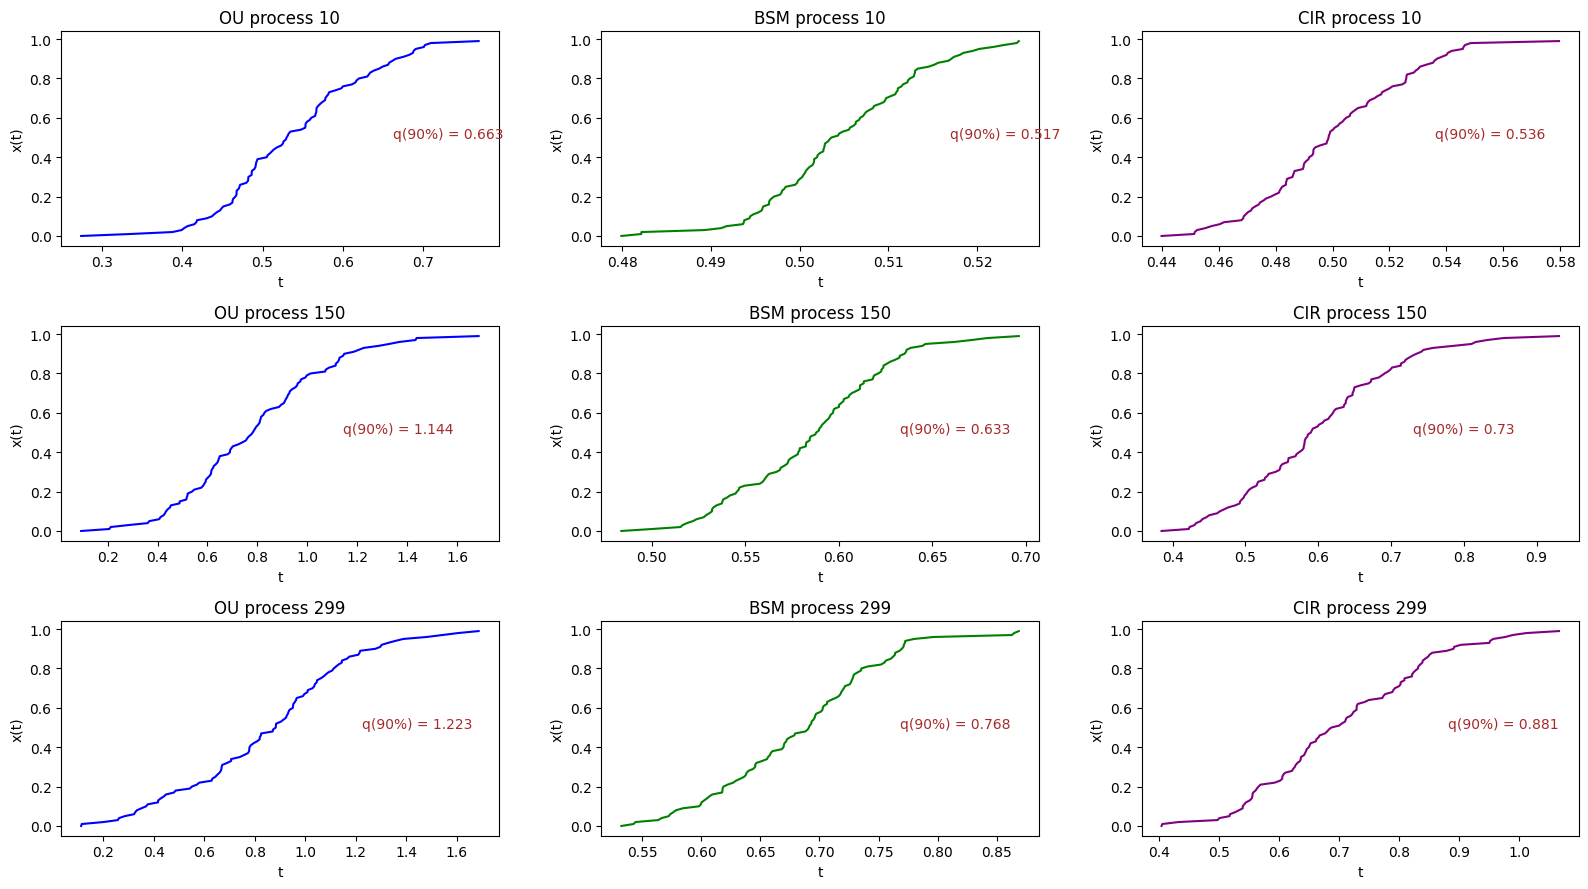

In [ ]:
#cdf function and 90% quantile

#distributions become more widely and change with time

fig, axs = plt.subplots(3, 3, figsize=(16, 9))

n = 10

axs[0][0].plot(*ecdf(x_data_OU[n]), color='blue')
axs[0][0].set_title(f'OU process {n}')
val = round(np.quantile(x_data_OU[n], 0.9),3)
axs[0][0].text(val, 0.5, f"q(90%) = {val}", color = 'brown')

axs[0][1].plot(*ecdf(x_data_BSM[n]), color='green')
axs[0][1].set_title(f'BSM process {n}')
val = round(np.quantile(x_data_BSM[n], 0.9),3)
axs[0][1].text(val, 0.5, f"q(90%) = {val}", color = 'brown')

axs[0][2].plot(*ecdf(x_data_CIR[n]), color='purple')
axs[0][2].set_title(f'CIR process {n}')
val = round(np.quantile(x_data_CIR[n], 0.9),3)
axs[0][2].text(val, 0.5, f"q(90%) = {val}", color = 'brown')

n = Nt // 2
axs[1][0].plot(*ecdf(x_data_OU[n]), color='blue')
axs[1][0].set_title(f'OU process {n}')
val = round(np.quantile(x_data_OU[n], 0.9),3)
axs[1][0].text(val, 0.5, f"q(90%) = {val}", color = 'brown')

axs[1][1].plot(*ecdf(x_data_BSM[n]), color='green')
axs[1][1].set_title(f'BSM process {n}')
val = round(np.quantile(x_data_BSM[n], 0.9),3)
axs[1][1].text(val, 0.5, f"q(90%) = {val}", color = 'brown')

axs[1][2].plot(*ecdf(x_data_CIR[n]), color='purple')
axs[1][2].set_title(f'CIR process {n}')
val = round(np.quantile(x_data_CIR[n], 0.9),3)
axs[1][2].text(val, 0.5, f"q(90%) = {val}", color = 'brown')

n = Nt - 1
axs[2][0].plot(*ecdf(x_data_OU[n]), color='blue')
axs[2][0].set_title(f'OU process {n}')
val = round(np.quantile(x_data_OU[n], 0.9),3)
axs[2][0].text(val, 0.5, f"q(90%) = {val}", color = 'brown')

axs[2][1].plot(*ecdf(x_data_BSM[n]), color='green')
axs[2][1].set_title(f'BSM process {n}')
val = round(np.quantile(x_data_BSM[n], 0.9),3)
axs[2][1].text(val, 0.5, f"q(90%) = {val}", color = 'brown')

axs[2][2].plot(*ecdf(x_data_CIR[n]), color='purple')
axs[2][2].set_title(f'CIR process {n}')
val = round(np.quantile(x_data_CIR[n], 0.9),3)
axs[2][2].text(val, 0.5, f"q(90%) = {val}", color = 'brown')

for k in range(0, 3):
    for j in range(0, 3):
        #axs[k][j].set_ylim(0, 1)
        #axs[k][j].set_xlim(0, 2)
        axs[k][j].set_xlabel('t')
        axs[k][j].set_ylabel('x(t)')

plt.tight_layout()
plt.show()

Task. Perform the Kolmogorov-Smirnov test for two samples and present your conclusions. Add vertical lines (90\%-quantile) into plots.
Resize the range on the X-axis so that all curves for one process have the same range.    

KS statistic: 0.242, P-value: 4.2252283893369713e-26


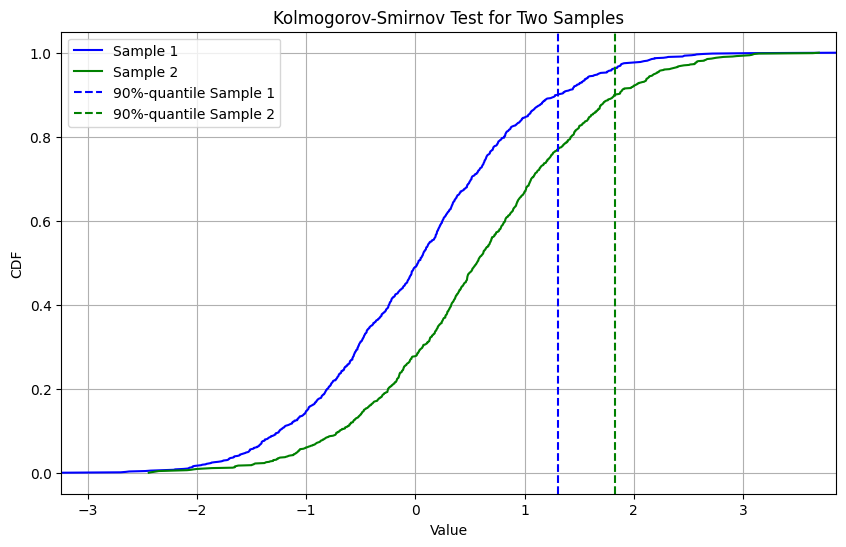

Распределения статистически значимо различаются.


In [35]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ks_2samp

# Примерные данные (две выборки, сгенерируем их случайно для примера)
np.random.seed(42)
sample1 = np.random.normal(loc=0, scale=1, size=1000)  # Первая выборка
sample2 = np.random.normal(loc=0.5, scale=1, size=1000)  # Вторая выборка

# 1. Проведение теста Колмогорова-Смирнова
ks_stat, p_value = ks_2samp(sample1, sample2)
print(f"KS statistic: {ks_stat}, P-value: {p_value}")

# 2. Построение графиков CDF для двух выборок
def plot_cdf(sample, label, color):
    # Сортируем выборку
    sorted_sample = np.sort(sample)
    # Генерируем CDF
    cdf = np.arange(1, len(sorted_sample)+1) / len(sorted_sample)
    # Строим график
    plt.plot(sorted_sample, cdf, label=label, color=color)

# Построение CDF для обеих выборок
plt.figure(figsize=(10, 6))
plot_cdf(sample1, label="Sample 1", color='blue')
plot_cdf(sample2, label="Sample 2", color='green')

# 3. Добавление вертикальных линий, соответствующих 90%-квантилям
quantile_90_sample1 = np.percentile(sample1, 90)
quantile_90_sample2 = np.percentile(sample2, 90)

plt.axvline(x=quantile_90_sample1, color='blue', linestyle='--', label="90%-quantile Sample 1")
plt.axvline(x=quantile_90_sample2, color='green', linestyle='--', label="90%-quantile Sample 2")

# 4. Установка одинакового диапазона на оси X
plt.xlim(min(min(sample1), min(sample2)), max(max(sample1), max(sample2)))

# Настройки графика
plt.title("Kolmogorov-Smirnov Test for Two Samples")
plt.xlabel("Value")
plt.ylabel("CDF")
plt.legend()
plt.grid(True)
plt.show()

# Вывод результатов теста
if p_value < 0.05:
    print("Распределения статистически значимо различаются.")
else:
    print("Нет статистически значимых различий между распределениями.")

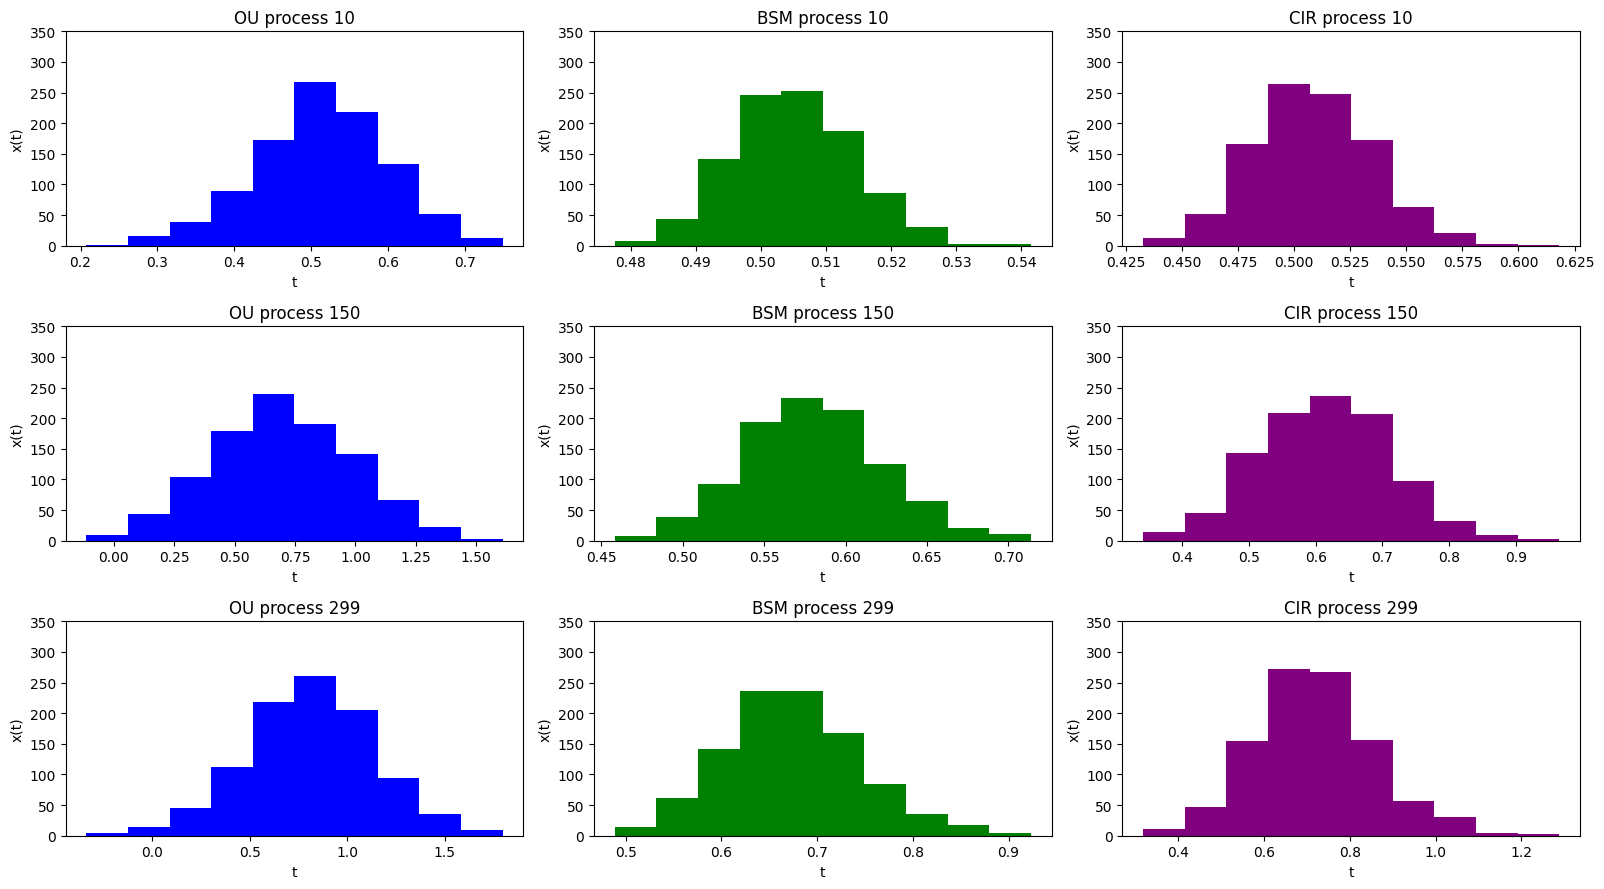

In [ ]:
#density function

fig, axs = plt.subplots(3, 3, figsize=(16, 9))

n = 10

axs[0][0].hist(x_data_OU[n], color='blue')
axs[0][0].set_title(f'OU process {n}')

axs[0][1].hist(x_data_BSM[n], color='green')
axs[0][1].set_title(f'BSM process {n}')

axs[0][2].hist(x_data_CIR[n], color='purple')
axs[0][2].set_title(f'CIR process {n}')

n = Nt // 2
axs[1][0].hist(x_data_OU[n], color='blue')
axs[1][0].set_title(f'OU process {n}')

axs[1][1].hist(x_data_BSM[n], color='green')
axs[1][1].set_title(f'BSM process {n}')

axs[1][2].hist(x_data_CIR[n], color='purple')
axs[1][2].set_title(f'CIR process {n}')

n = Nt - 1
axs[2][0].hist(x_data_OU[n], color='blue')
axs[2][0].set_title(f'OU process {n}')

axs[2][1].hist(x_data_BSM[n], color='green')
axs[2][1].set_title(f'BSM process {n}')

axs[2][2].hist(x_data_CIR[n], color='purple')
axs[2][2].set_title(f'CIR process {n}')

for k in range(0, 3):
    for j in range(0, 3):
        axs[k][j].set_ylim(0, 350)
        #axs[k][j].set_xlim(0, 2)
        axs[k][j].set_xlabel('t')
        axs[k][j].set_ylabel('x(t)')

plt.tight_layout()

plt.show()

Task. Perform a normality test on the histograms and present your conclusions.

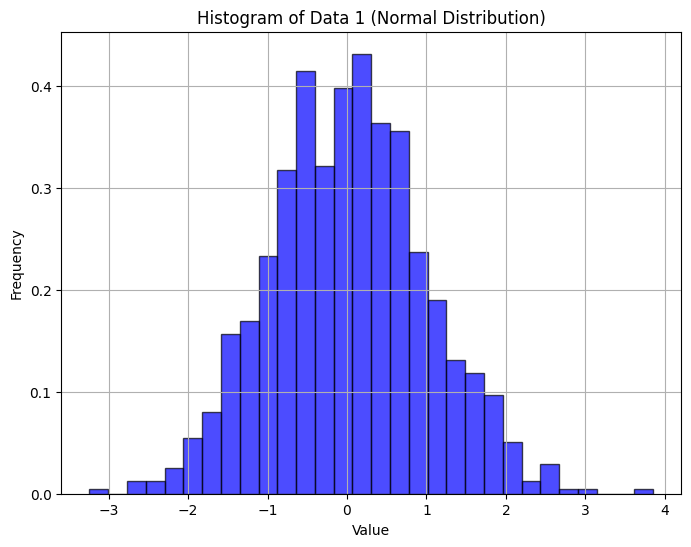

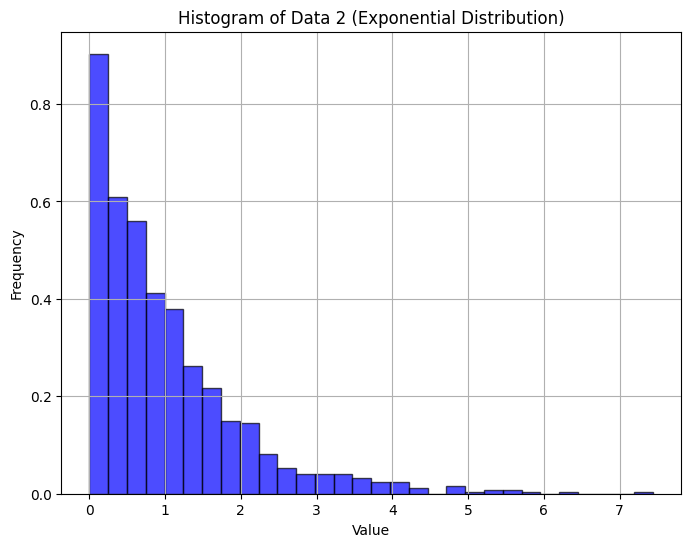

Shapiro-Wilk Test for Data 1:
  Test Statistic: 0.9986080527305603
  P-value: 0.6264819502830505
  Conclusion: Data 1 seems to be normally distributed.

D'Agostino's K-squared Test for Data 1:
  Test Statistic: 2.5755178543216046
  P-value: 0.2758883767428564
  Conclusion: Data 1 seems to be normally distributed.

Anderson-Darling Test for Data 1:
  Test Statistic: 0.3474697767348971
  Critical Values (for significance levels):
    15.0%: 0.574
    10.0%: 0.653
    5.0%: 0.784
    2.5%: 0.914
    1.0%: 1.088
  Conclusion: Data 1 seems to be normally distributed.

Shapiro-Wilk Test for Data 2:
  Test Statistic: 0.8155859708786011
  P-value: 2.5207480121921634e-32
  Conclusion: Data 2 is not normally distributed.

D'Agostino's K-squared Test for Data 2:
  Test Statistic: 422.69944685132356
  P-value: 1.6292261211702495e-92
  Conclusion: Data 2 is not normally distributed.

Anderson-Darling Test for Data 2:
  Test Statistic: 45.29756757774976
  Critical Values (for significance levels):
 

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import shapiro, normaltest, anderson

# Генерация примерных данных (можете заменить эти данные на ваши)
np.random.seed(42)
data1 = np.random.normal(loc=0, scale=1, size=1000)  # Нормально распределенные данные
data2 = np.random.exponential(scale=1, size=1000)  # Данные с экспоненциальным распределением

# 1. Построение гистограмм для визуального анализа
def plot_histogram(data, title):
    plt.figure(figsize=(8, 6))
    plt.hist(data, bins=30, alpha=0.7, color='blue', edgecolor='black', density=True)
    plt.title(f"Histogram of {title}")
    plt.xlabel("Value")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()

# Построим гистограммы
plot_histogram(data1, "Data 1 (Normal Distribution)")
plot_histogram(data2, "Data 2 (Exponential Distribution)")

# 2. Тесты на нормальность

# Тест Шапиро-Уилка
def perform_shapiro_test(data, data_name):
    stat, p_value = shapiro(data)
    print(f"Shapiro-Wilk Test for {data_name}:")
    print(f"  Test Statistic: {stat}")
    print(f"  P-value: {p_value}")
    if p_value > 0.05:
        print(f"  Conclusion: {data_name} seems to be normally distributed.\n")
    else:
        print(f"  Conclusion: {data_name} is not normally distributed.\n")

# Тест Д’Агостино (normaltest)
def perform_dagostino_test(data, data_name):
    stat, p_value = normaltest(data)
    print(f"D'Agostino's K-squared Test for {data_name}:")
    print(f"  Test Statistic: {stat}")
    print(f"  P-value: {p_value}")
    if p_value > 0.05:
        print(f"  Conclusion: {data_name} seems to be normally distributed.\n")
    else:
        print(f"  Conclusion: {data_name} is not normally distributed.\n")

# Тест Андерсона-Дарлинга
def perform_anderson_test(data, data_name):
    result = anderson(data, dist='norm')
    print(f"Anderson-Darling Test for {data_name}:")
    print(f"  Test Statistic: {result.statistic}")
    print("  Critical Values (for significance levels):")
    for i in range(len(result.critical_values)):
        sl, cv = result.significance_level[i], result.critical_values[i]
        print(f"    {sl}%: {cv}")
    if result.statistic < result.critical_values[2]:  # Для уровня значимости 5%
        print(f"  Conclusion: {data_name} seems to be normally distributed.\n")
    else:
        print(f"  Conclusion: {data_name} is not normally distributed.\n")

# Выполним тесты на нормальность для Data 1
perform_shapiro_test(data1, "Data 1")
perform_dagostino_test(data1, "Data 1")
perform_anderson_test(data1, "Data 1")

# Выполним тесты на нормальность для Data 2
perform_shapiro_test(data2, "Data 2")
perform_dagostino_test(data2, "Data 2")
perform_anderson_test(data2, "Data 2")